In [1]:
import os
import sys
import warnings

from glob import glob
import random
import datetime
import re
from tqdm import tqdm

import pandas as pd
import numpy as np

from google.cloud import bigquery

import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

import gspread
from oauth2client.service_account import ServiceAccountCredentials

from plotnine import *

warnings.filterwarnings('ignore')

In [2]:
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
font = fm.FontProperties(fname=path, size=9)

NanumGothic


In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', -1)
pd.options.display.float_format = '{:.2f}'.format

In [4]:
def read_bql(file_name) :
    with open(file_name, "r") as f :
        bql = f.read()
    return bql


def bigquery_to_pandas(query_string) :

    credential_path = '../99_credential/lawtalk-bigquery-2bfd97cf0729.json'
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credential_path
    bqclient = bigquery.Client()
    
    b = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(
            # Optionally, explicitly request to use the BigQuery Storage API. As of
            # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
            # API is used by default.
            create_bqstorage_client=True,
        )
    )
    
    return b

In [5]:
def get_gini(df, val_col, group_key = None, color = "red", plot_tf = True) :
    tmp = df.copy()
    tmp["ratio"] = tmp[val_col] / tmp[val_col].max()
    tmp["rnk"] = tmp.ratio.rank(method = "first")  / tmp.shape[0]
    tmp = tmp.sort_values("rnk")
    tmp["eq_line"] = [i / tmp.shape[0] for i in range(tmp.shape[0])]
    
    lorenz = (tmp.rnk * tmp.shape[0] * (tmp.ratio / tmp.shape[0])).sum()
    tri = ((tmp.rnk * tmp.shape[0]).max() * tmp.rnk.max()) / 2
    if group_key == None :
        col_plot = geom_col(mapping = aes(x = "rnk", y = "ratio"), fill = color, alpha = 0.6)
    else :
        col_plot = geom_col(mapping = aes(x = "rnk", y = "ratio", fill = group_key), alpha = 0.6)

    
    if plot_tf == True :
        print((
            ggplot(data = tmp) +
            col_plot +
            geom_line(mapping = aes(x = "rnk", y = "eq_line"), group = 1) +
            theme_bw() +
            theme(figure_size = (10, 7), text = element_text(angle = 90, fontproperties = font), axis_title=element_blank())
        ))
    
    return (tri - lorenz) / tri

def ad_active(df, d) :
    return (df.adorders_start_date <= d) & (df.adorders_end_date >= d) & ~((df.pauseHistory_startAt_date <= d) & (df.pauseHistory_endAt_date >= d)) & (df.adorders_status == 'apply') & (df.adpayments_status == 'paid')

def ad_active_dates(df, date_list) :
    return pd.concat([df[ad_active(df, d)] for d in date_list]).drop_duplicates()

def prefix_rnk(df, str_cols, y_cols, zfill_ns = 2) :
    return df[y_cols].rank(ascending = False).astype(int).astype(str).str.zfill(zfill_ns) + "_" + df[str_cols]

In [6]:
advice = bigquery_to_pandas(read_bql("../bql/advice_query.bql"))
adorders = bigquery_to_pandas(read_bql("../bql/adorders_query.bql"))

In [7]:
date_range = pd.date_range(datetime.date(2022, 7, 1), datetime.date(2022, 7, 15))

In [8]:
extract_adorders = ad_active_dates(adorders, date_range)
extract_advice = advice[(advice.adCategory_name != '기타') & (advice.createdAt.dt.date.isin(date_range.date))]

In [9]:
tmp = pd.merge(ad_active_dates(adorders, date_range).groupby("adCategory_name").slug.nunique().sort_values(ascending = False).reset_index().rename(columns = {"slug" : "lawyer_cnt"}), advice[(advice.adCategory_name != '기타') & (advice.createdAt.dt.date.isin(date_range.date))].groupby("adCategory_name")._id.count().sort_values(ascending = False).reset_index().rename(columns = {"_id" : "advice_cnt"}), on = "adCategory_name")

tmp["ratio"] = tmp.advice_cnt / tmp.lawyer_cnt
tmp["rnk_category"] = prefix_rnk(tmp, "adCategory_name", "ratio")
tmp_ = pd.melt(tmp.drop(columns = "adCategory_name"), id_vars = "rnk_category")

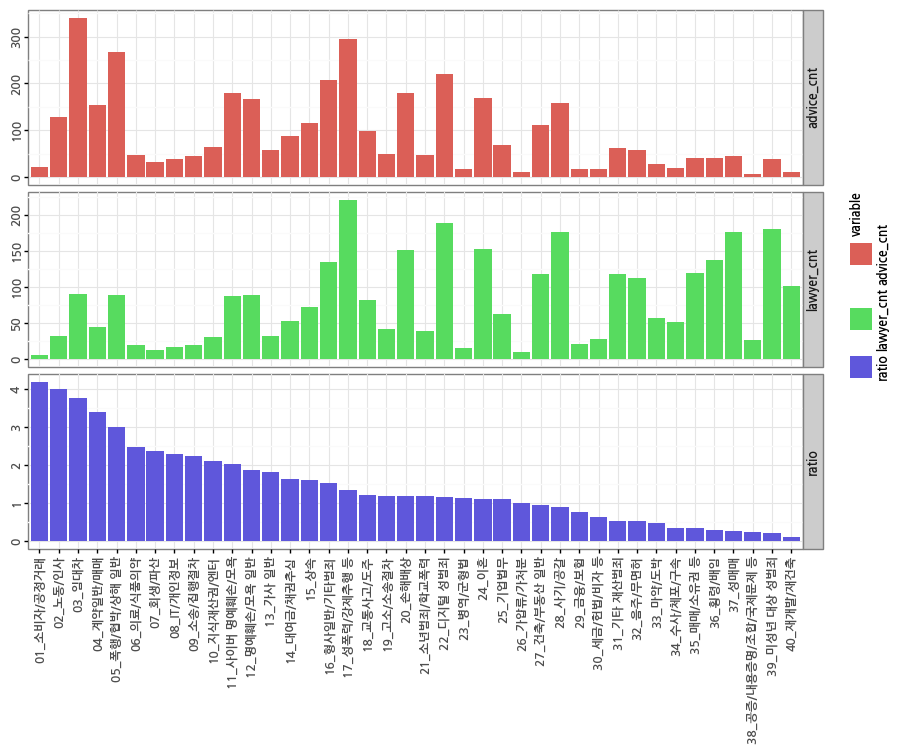

<ggplot: (8783514398507)>

In [10]:
(
    ggplot() +
    geom_col(data = tmp_, mapping = aes(x = "rnk_category", y = "value", fill = "variable")) +
    facet_grid("variable~.", scales = "free_y") +
    theme_bw() +
    theme(figure_size = (10, 7), text = element_text(angle = 90, fontproperties = font), axis_title=element_blank())
)

### 7월 1 ~ 15일까지의 분야별 유료 상담 불평등도

1.임대차 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 90 / 56 / 41
임대차 분야 총 상담 수 = 340


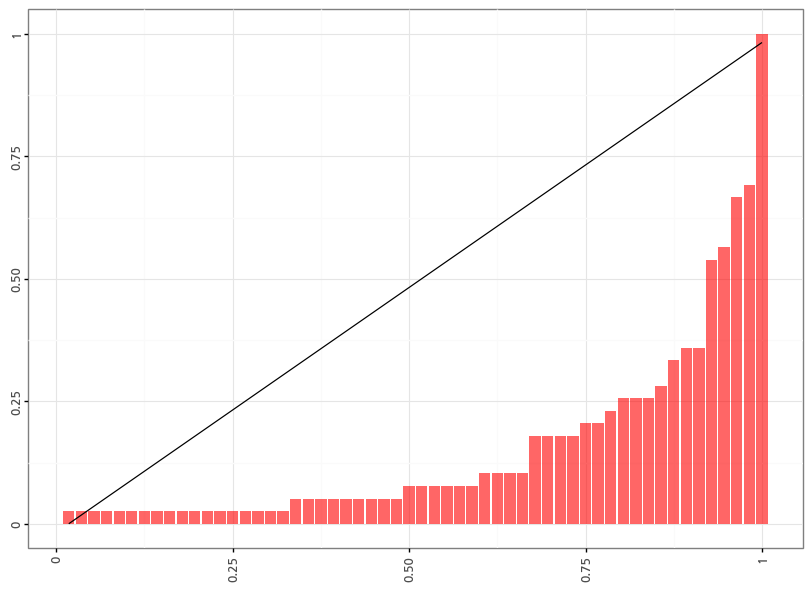


임대차 분야 불평등도 = 0.7518642072213501
--------------------------------------------------



2.성폭력/강제추행 등 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 221 / 78 / 74
성폭력/강제추행 등 분야 총 상담 수 = 295


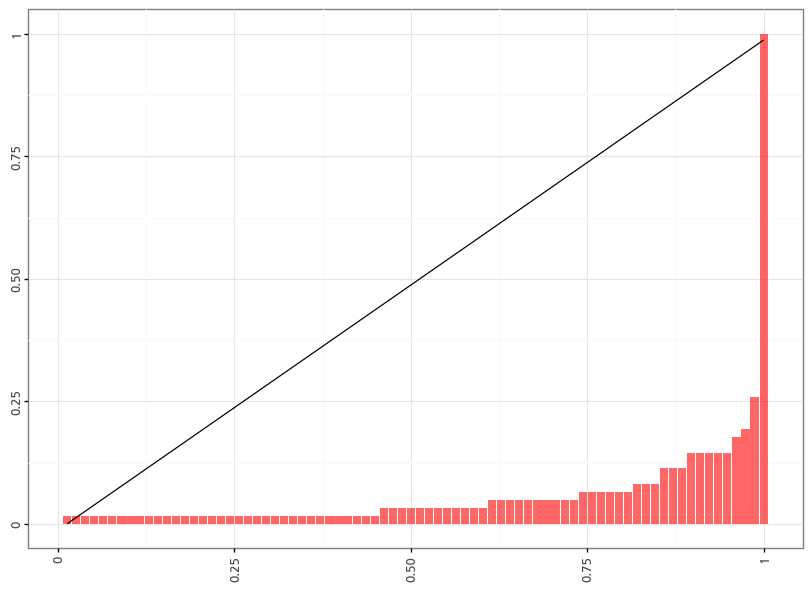


성폭력/강제추행 등 분야 불평등도 = 0.9040264257385846
--------------------------------------------------



3.폭행/협박/상해 일반 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 89 / 79 / 51
폭행/협박/상해 일반 분야 총 상담 수 = 267


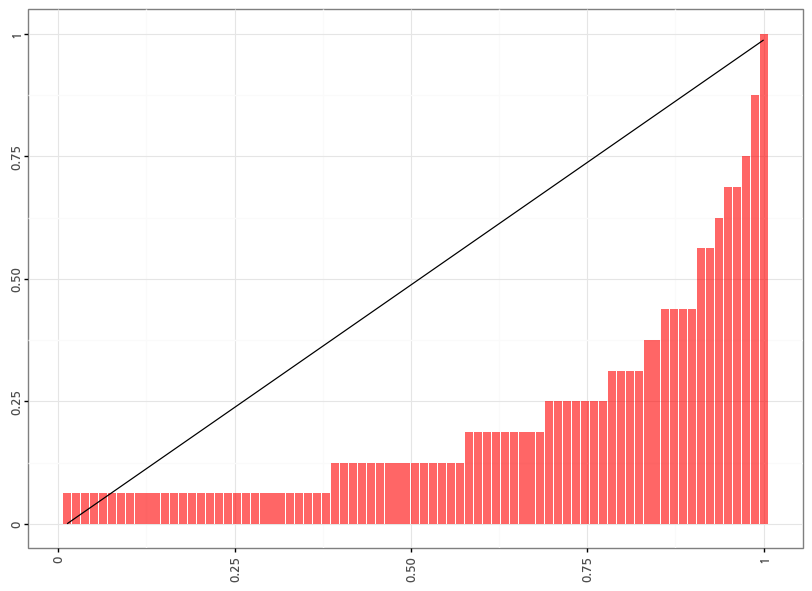


폭행/협박/상해 일반 분야 불평등도 = 0.6879706777759975
--------------------------------------------------



4.디지털 성범죄 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 189 / 59 / 54
디지털 성범죄 분야 총 상담 수 = 219



디지털 성범죄 분야 불평등도 = 0.8030738293593795
--------------------------------------------------



5.형사일반/기타범죄 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 135 / 78 / 48
형사일반/기타범죄 분야 총 상담 수 = 208


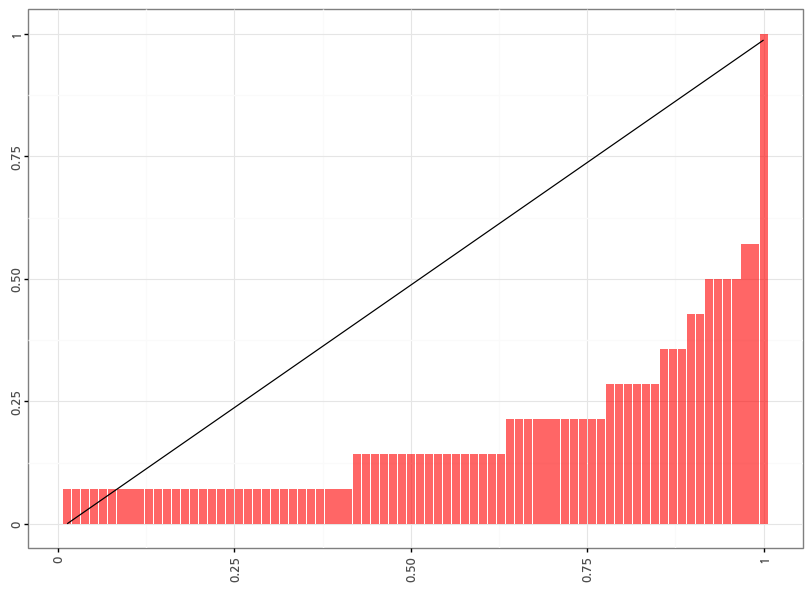


형사일반/기타범죄 분야 불평등도 = 0.7299474030243261
--------------------------------------------------



6.손해배상 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 151 / 81 / 41
손해배상 분야 총 상담 수 = 180


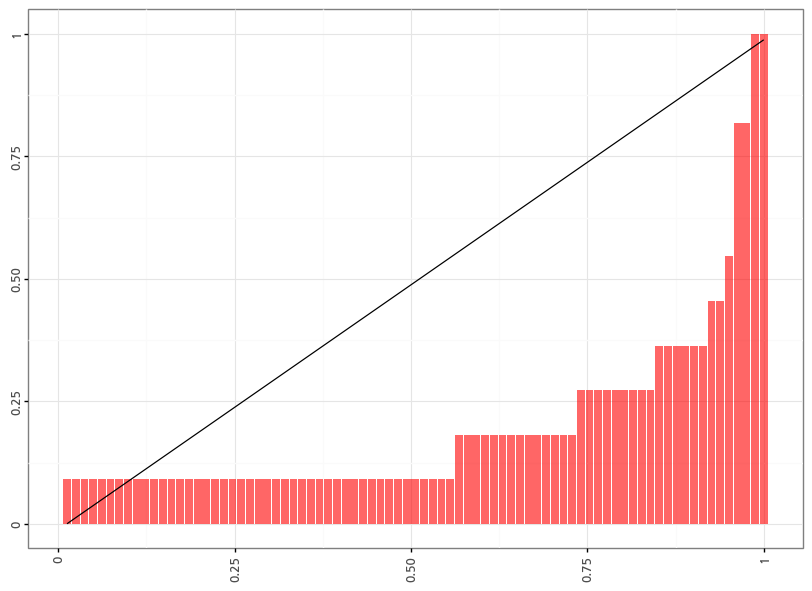


손해배상 분야 불평등도 = 0.7131811946626762
--------------------------------------------------



7.사이버 명예훼손/모욕 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 88 / 53 / 34
사이버 명예훼손/모욕 분야 총 상담 수 = 179


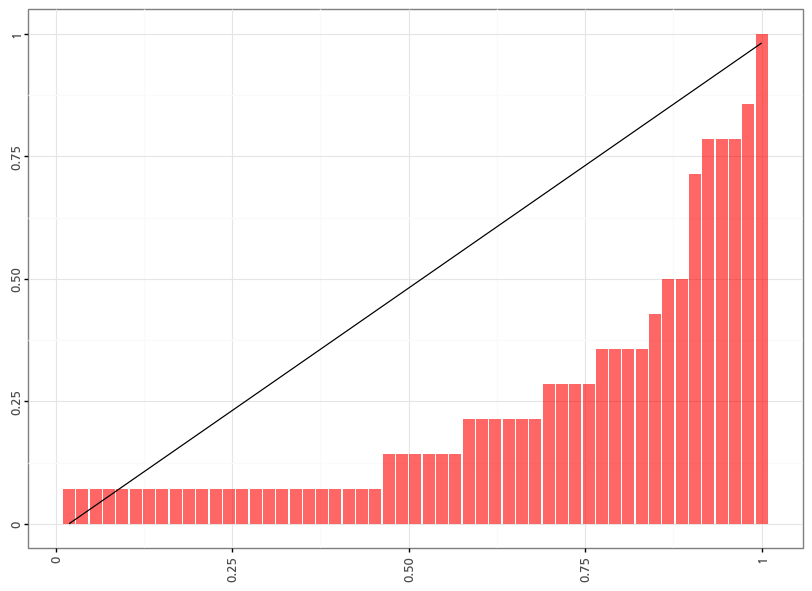


사이버 명예훼손/모욕 분야 불평등도 = 0.6381020190204955
--------------------------------------------------



8.이혼 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 153 / 56 / 51
이혼 분야 총 상담 수 = 169


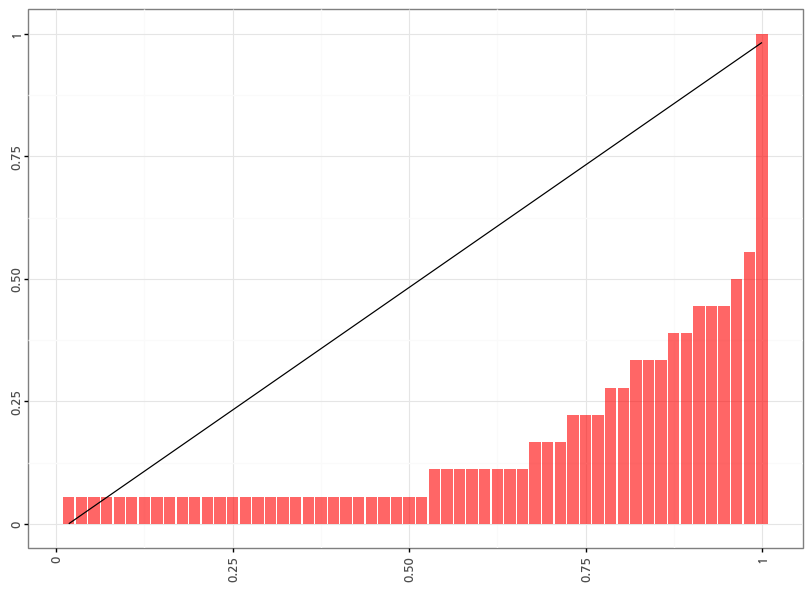


이혼 분야 불평등도 = 0.7483701814058957
--------------------------------------------------



9.명예훼손/모욕 일반 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 89 / 66 / 42
명예훼손/모욕 일반 분야 총 상담 수 = 167


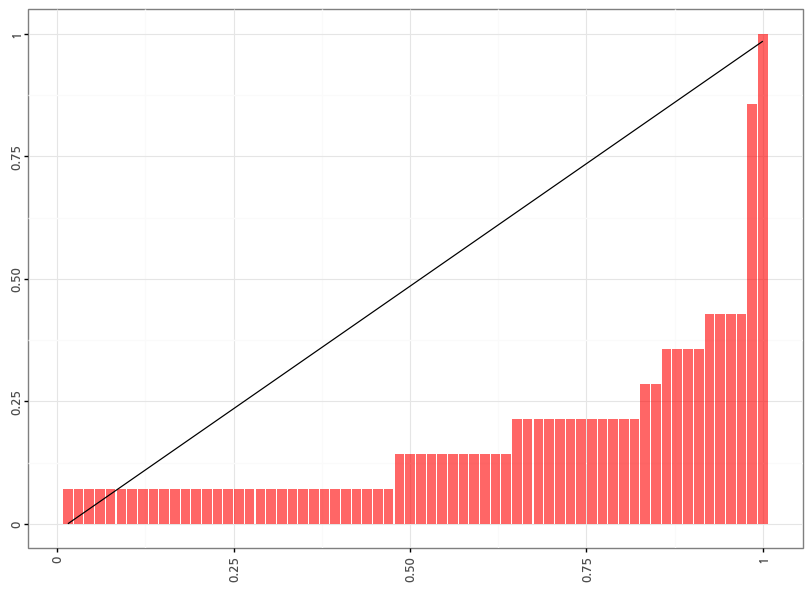


명예훼손/모욕 일반 분야 불평등도 = 0.7417683326774236
--------------------------------------------------



10.사기/공갈 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 177 / 77 / 55
사기/공갈 분야 총 상담 수 = 159


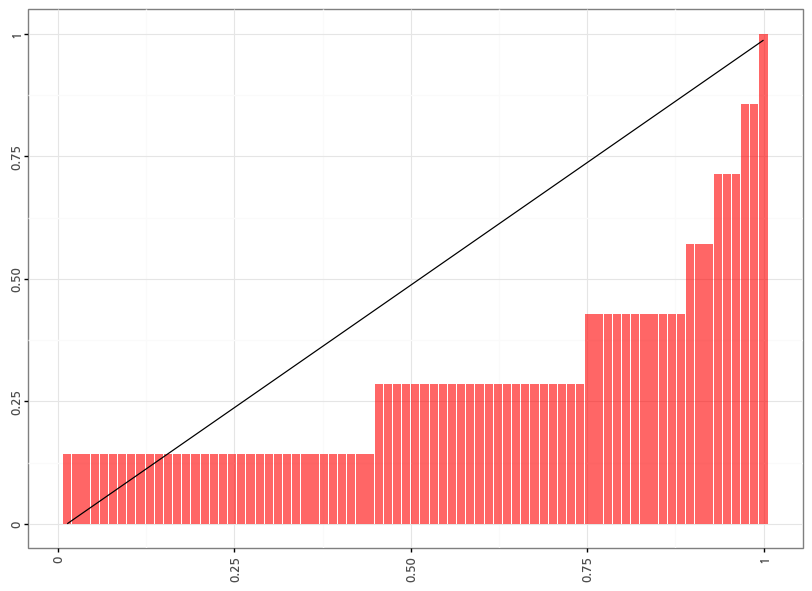


사기/공갈 분야 불평등도 = 0.6062935209502929
--------------------------------------------------



11.계약일반/매매 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 45 / 65 / 16
계약일반/매매 분야 총 상담 수 = 153


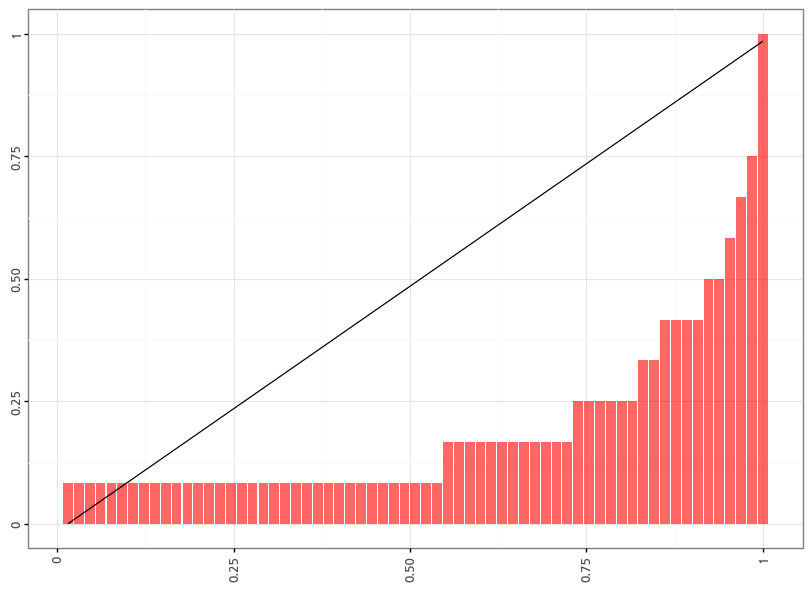


계약일반/매매 분야 불평등도 = 0.7183037475345168
--------------------------------------------------



12.노동/인사 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 32 / 23 / 13
노동/인사 분야 총 상담 수 = 128


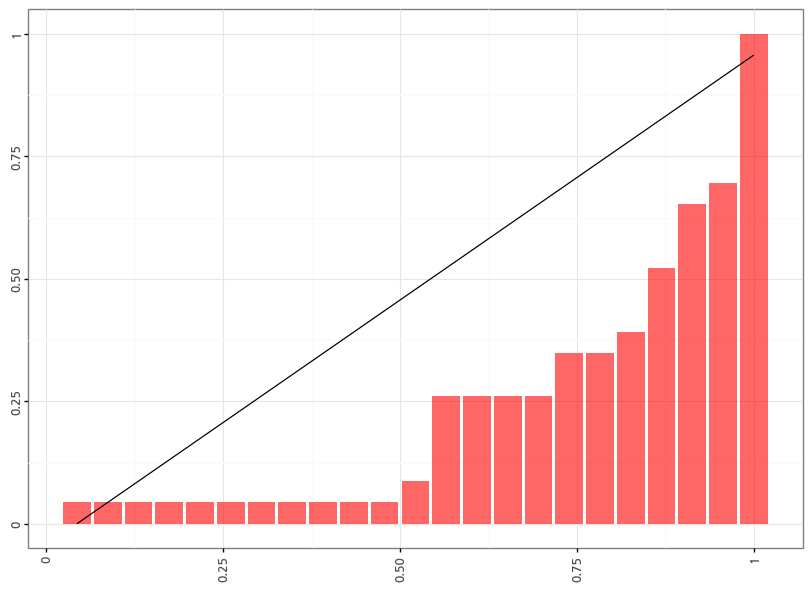


노동/인사 분야 불평등도 = 0.6178186898989069
--------------------------------------------------



13.상속 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 72 / 35 / 24
상속 분야 총 상담 수 = 116


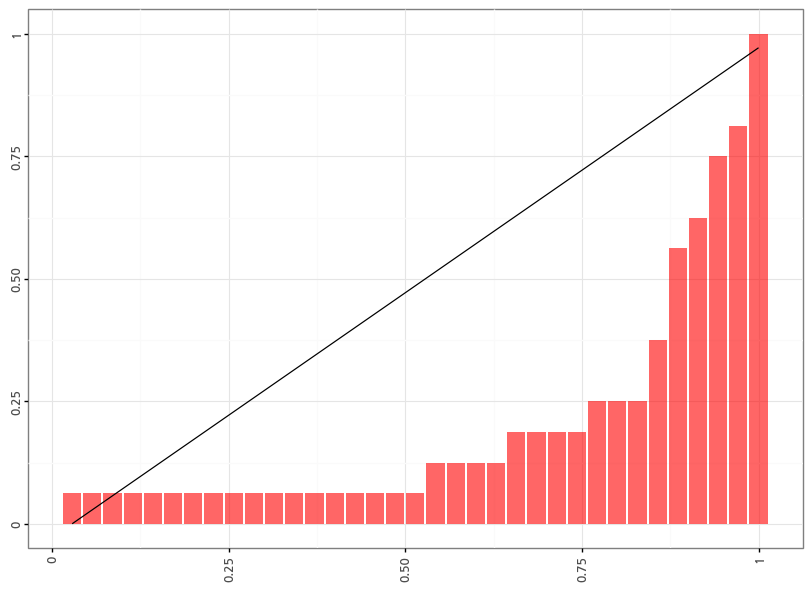


상속 분야 불평등도 = 0.6793877551020409
--------------------------------------------------



14.건축/부동산 일반 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 118 / 40 / 28
건축/부동산 일반 분야 총 상담 수 = 111



건축/부동산 일반 분야 불평등도 = 0.7230000000000001
--------------------------------------------------



15.교통사고/도주 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 82 / 38 / 27
교통사고/도주 분야 총 상담 수 = 99


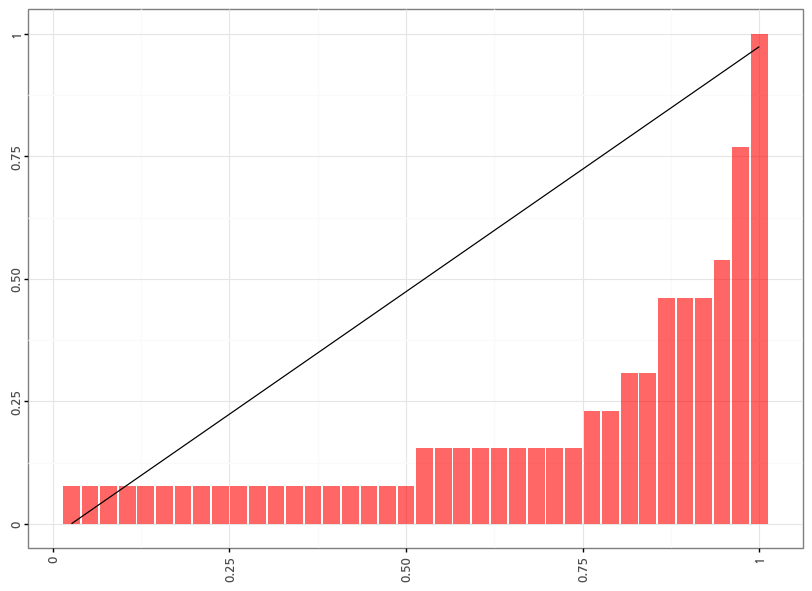


교통사고/도주 분야 불평등도 = 0.7039207330066056
--------------------------------------------------



16.대여금/채권추심 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 53 / 36 / 22
대여금/채권추심 분야 총 상담 수 = 87



대여금/채권추심 분야 불평등도 = 0.6626543209876543
--------------------------------------------------



17.기업법무 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 62 / 27 / 16
기업법무 분야 총 상담 수 = 68


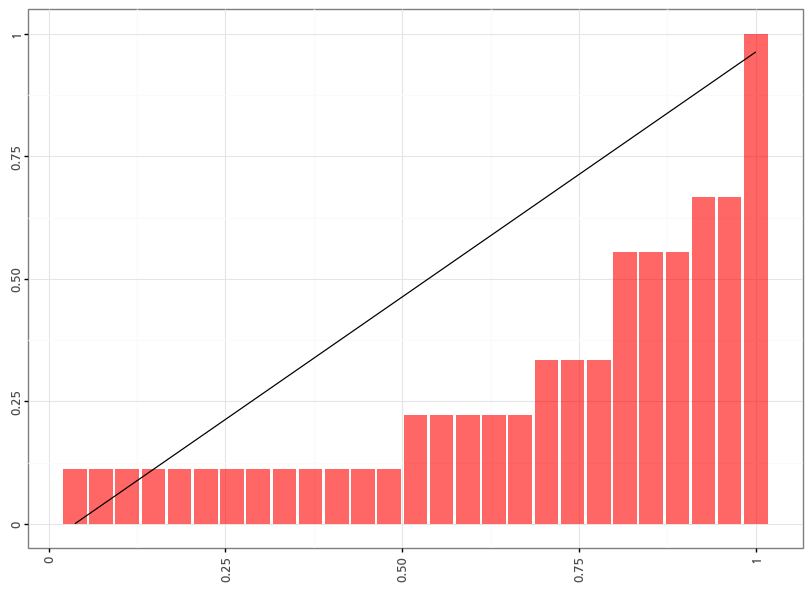


기업법무 분야 불평등도 = 0.5960981557689378
--------------------------------------------------



18.지식재산권/엔터 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 30 / 20 / 14
지식재산권/엔터 분야 총 상담 수 = 63



지식재산권/엔터 분야 불평등도 = 0.48611111111111116
--------------------------------------------------



19.기타 재산범죄 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 118 / 27 / 13
기타 재산범죄 분야 총 상담 수 = 62



기타 재산범죄 분야 불평등도 = 0.6919815438333956
--------------------------------------------------



20.음주/무면허 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 112 / 23 / 22
음주/무면허 분야 총 상담 수 = 58


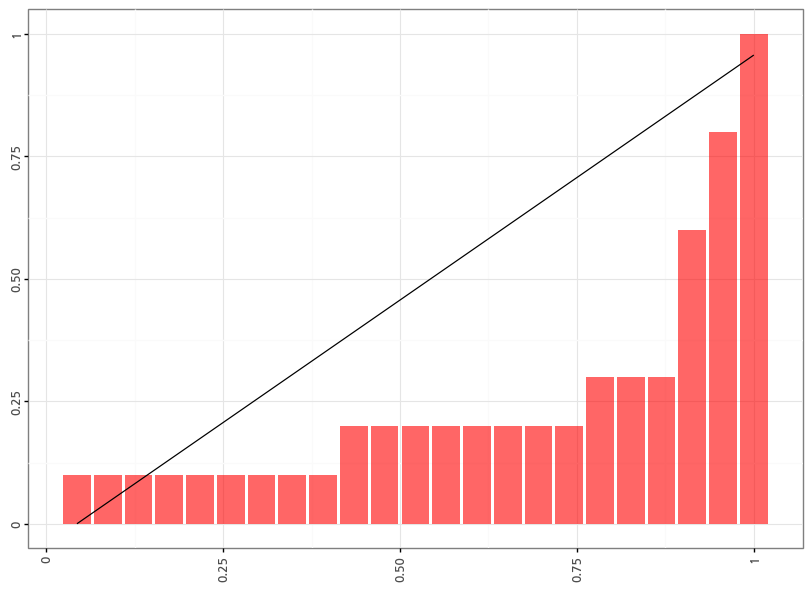


음주/무면허 분야 불평등도 = 0.635538752362949
--------------------------------------------------



21.가사 일반 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 32 / 26 / 10
가사 일반 분야 총 상담 수 = 58


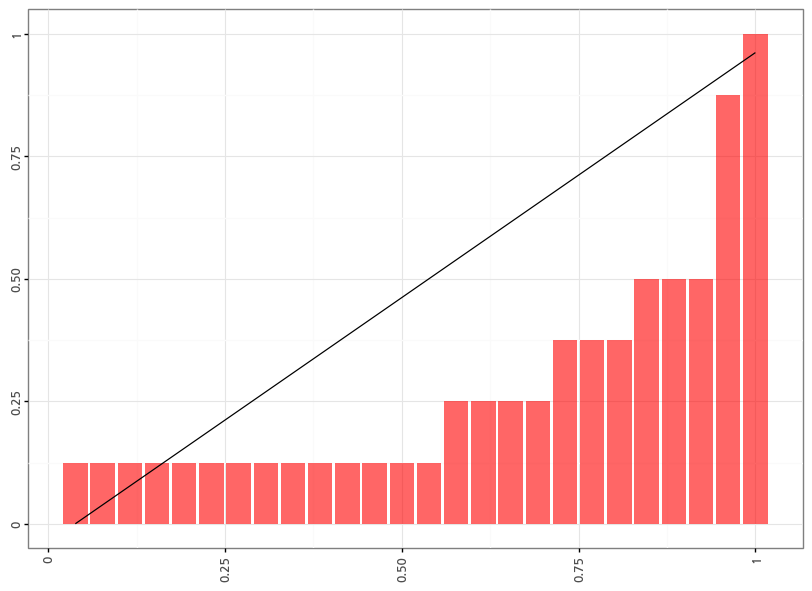


가사 일반 분야 불평등도 = 0.6020710059171598
--------------------------------------------------



22.고소/소송절차 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 41 / 26 / 9
고소/소송절차 분야 총 상담 수 = 49


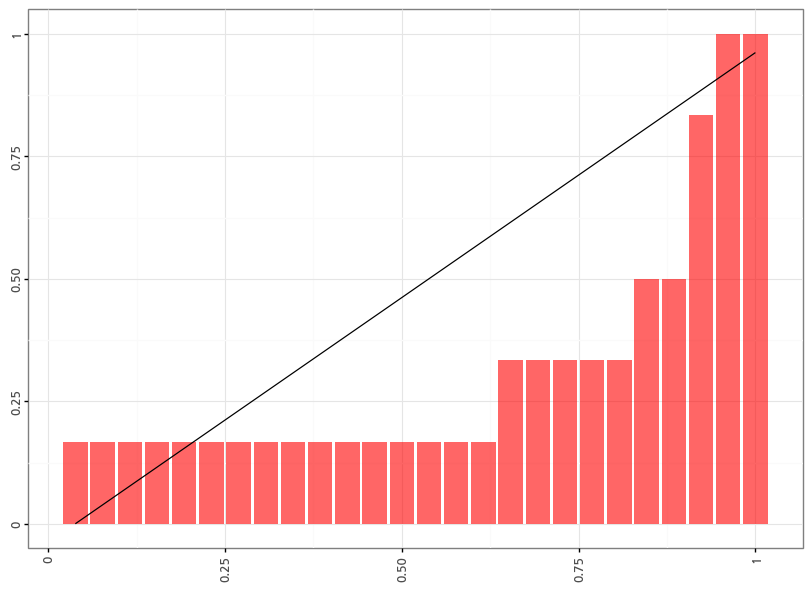


고소/소송절차 분야 불평등도 = 0.5626232741617356
--------------------------------------------------



23.의료/식품의약 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 19 / 14 / 7
의료/식품의약 분야 총 상담 수 = 47



의료/식품의약 분야 불평등도 = 0.6188046647230321
--------------------------------------------------



24.소년범죄/학교폭력 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 39 / 23 / 13
소년범죄/학교폭력 분야 총 상담 수 = 46


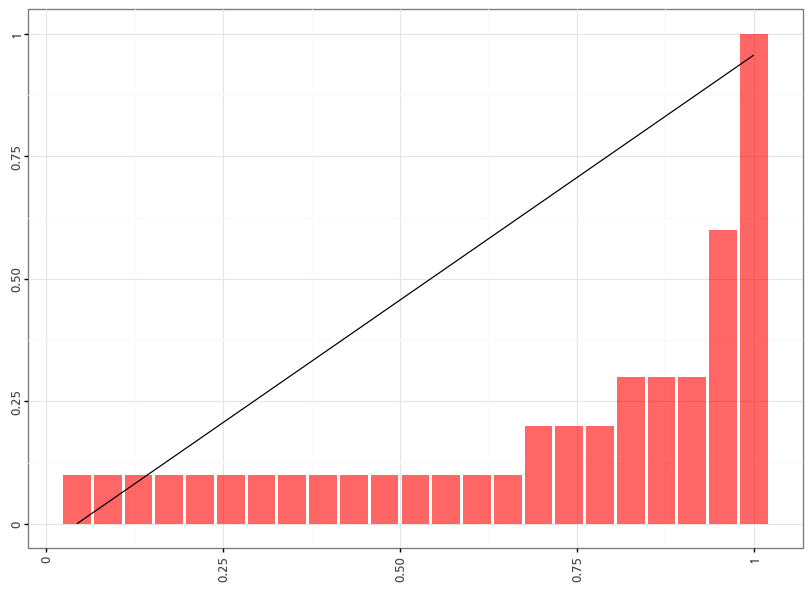


소년범죄/학교폭력 분야 불평등도 = 0.7111531190926277
--------------------------------------------------



25.성매매 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 176 / 28 / 26
성매매 분야 총 상담 수 = 45


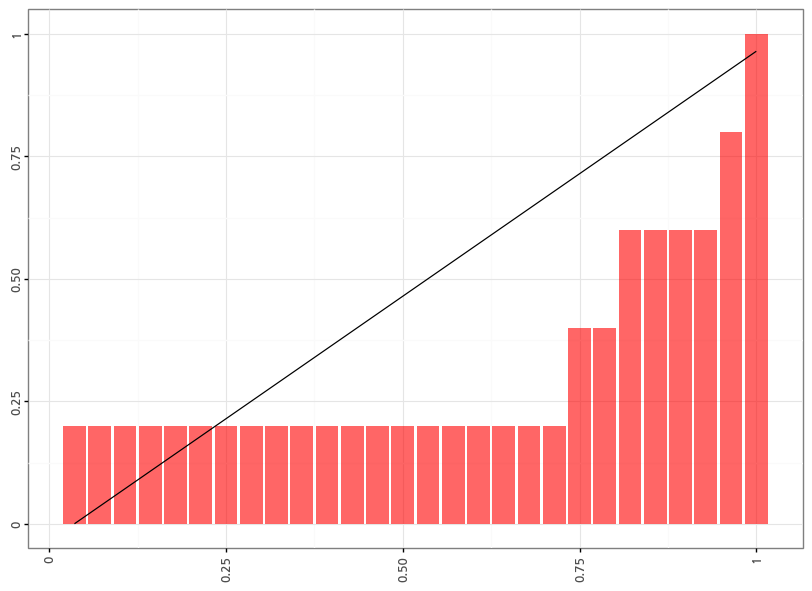


성매매 분야 불평등도 = 0.5724489795918367
--------------------------------------------------



26.소송/집행절차 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 20 / 27 / 7
소송/집행절차 분야 총 상담 수 = 45


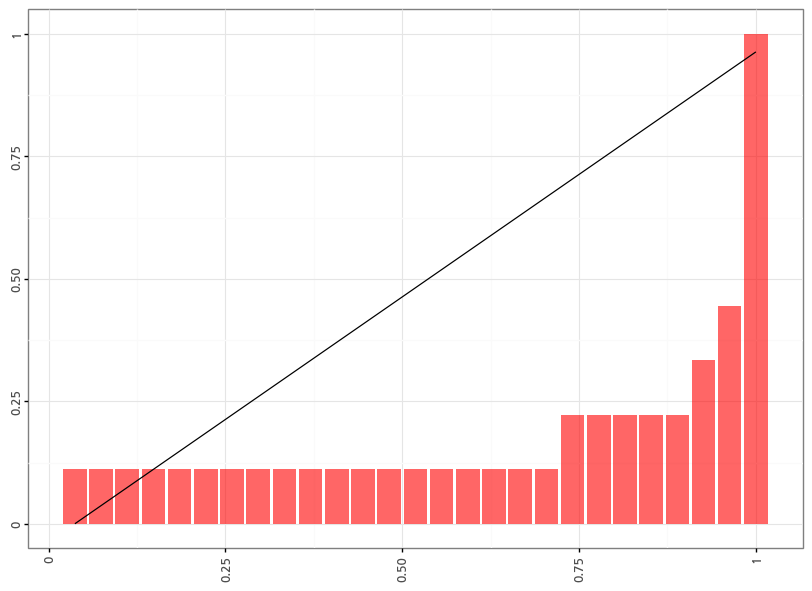


소송/집행절차 분야 불평등도 = 0.746380124980948
--------------------------------------------------



27.매매/소유권 등 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 120 / 19 / 14
매매/소유권 등 분야 총 상담 수 = 41


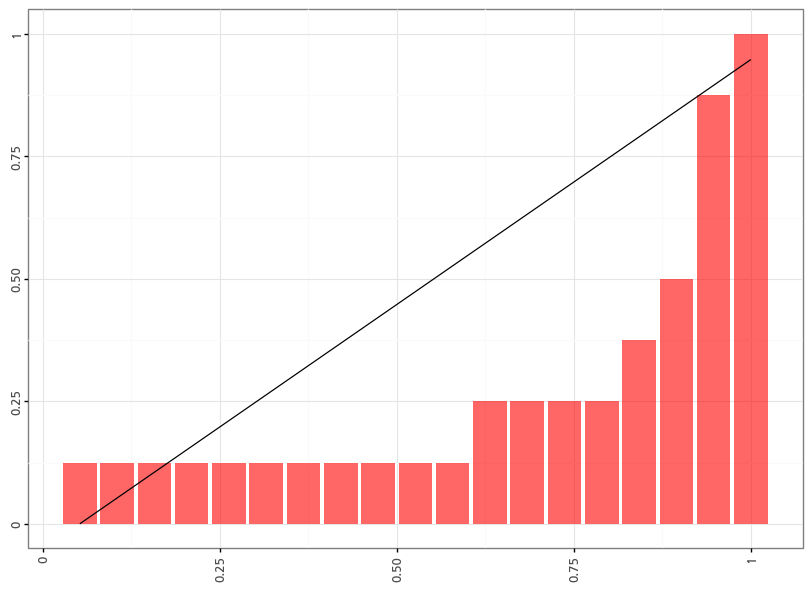


매매/소유권 등 분야 불평등도 = 0.6066481994459835
--------------------------------------------------



28.횡령/배임 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 138 / 22 / 18
횡령/배임 분야 총 상담 수 = 40


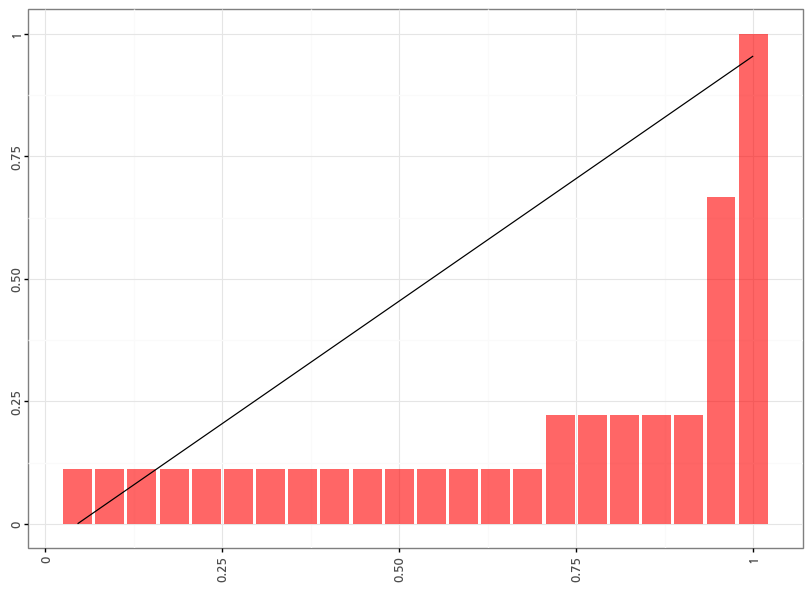


횡령/배임 분야 불평등도 = 0.7134986225895317
--------------------------------------------------



29.IT/개인정보 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 17 / 15 / 6
IT/개인정보 분야 총 상담 수 = 39


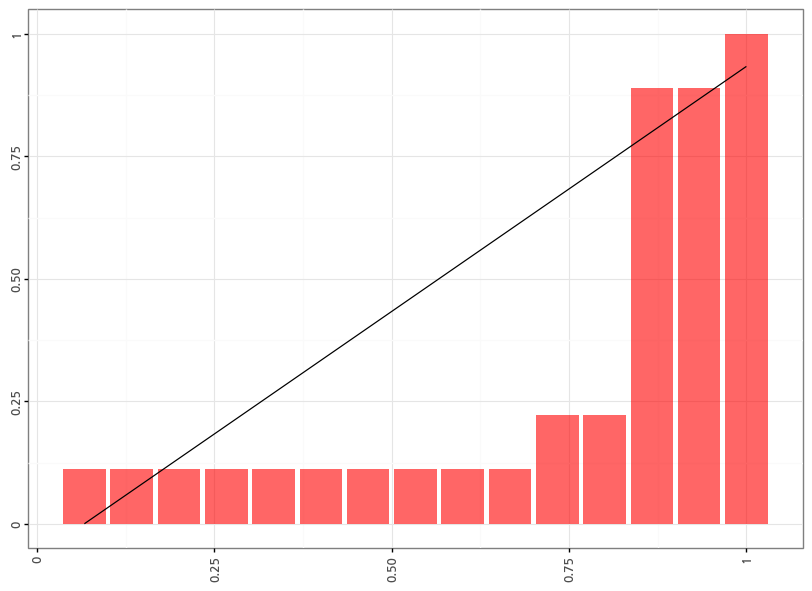


IT/개인정보 분야 불평등도 = 0.5535802469135802
--------------------------------------------------



30.미성년 대상 성범죄 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 181 / 15 / 12
미성년 대상 성범죄 분야 총 상담 수 = 38



미성년 대상 성범죄 분야 불평등도 = 0.6213333333333334
--------------------------------------------------



31.회생/파산 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 13 / 7 / 5
회생/파산 분야 총 상담 수 = 31


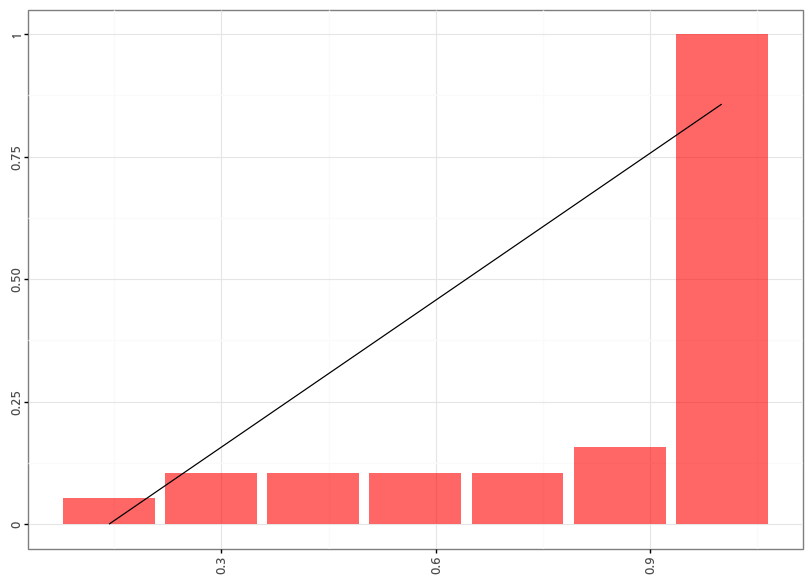


회생/파산 분야 불평등도 = 0.6133190118152524
--------------------------------------------------



32.마약/도박 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 57 / 13 / 12
마약/도박 분야 총 상담 수 = 27


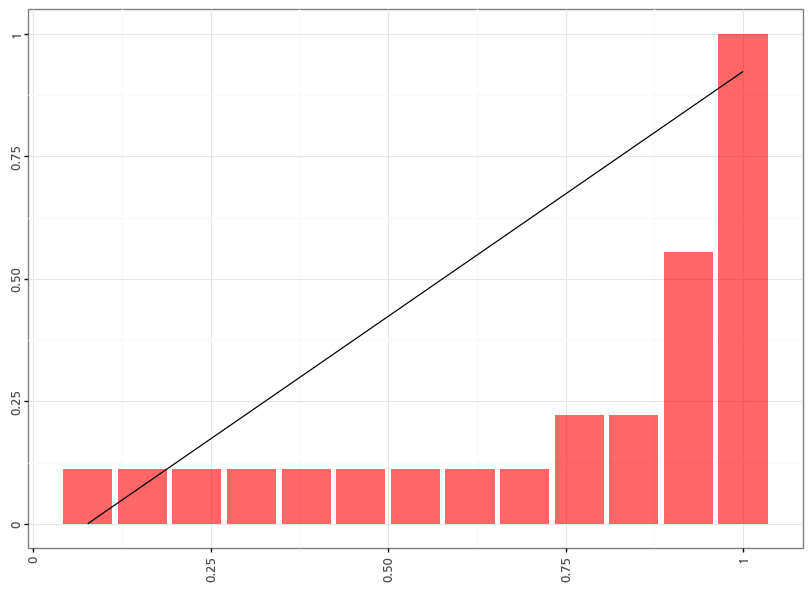


마약/도박 분야 불평등도 = 0.6528599605522682
--------------------------------------------------



33.소비자/공정거래 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 5 / 7 / 3
소비자/공정거래 분야 총 상담 수 = 21


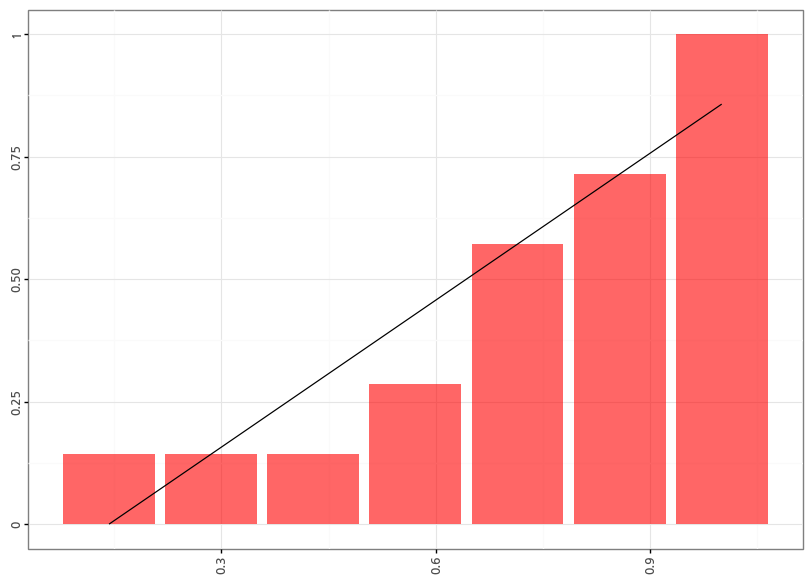


소비자/공정거래 분야 불평등도 = 0.3411078717201167
--------------------------------------------------



34.수사/체포/구속 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 51 / 16 / 6
수사/체포/구속 분야 총 상담 수 = 18



수사/체포/구속 분야 불평등도 = 0.34765625
--------------------------------------------------



35.세금/헌법/비자 등 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 27 / 9 / 4
세금/헌법/비자 등 분야 총 상담 수 = 17


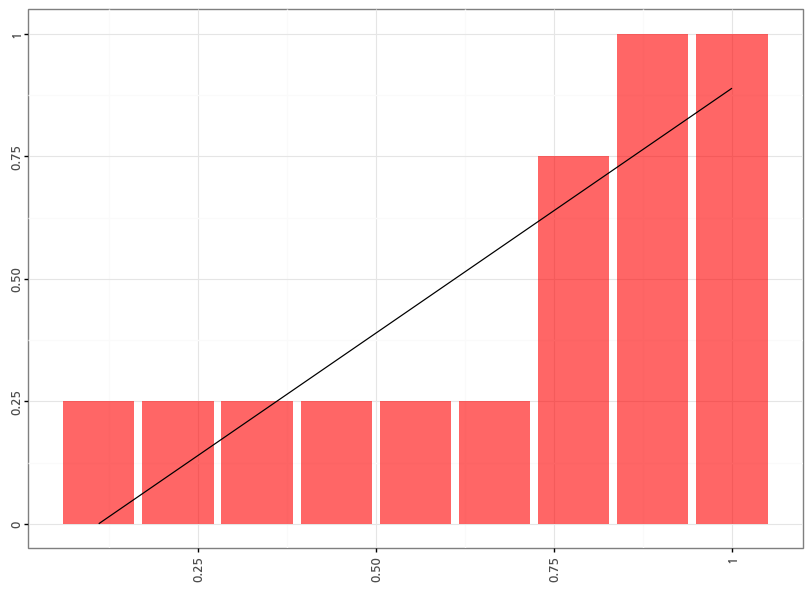


세금/헌법/비자 등 분야 불평등도 = 0.3209876543209877
--------------------------------------------------



36.병역/군형법 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 15 / 6 / 5
병역/군형법 분야 총 상담 수 = 17


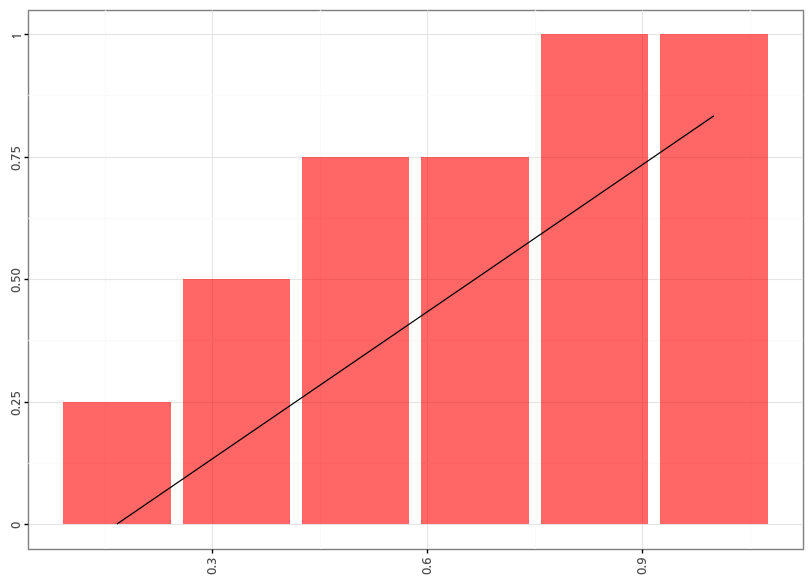


병역/군형법 분야 불평등도 = 0.02777777777777783
--------------------------------------------------



37.금융/보험 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 21 / 6 / 2
금융/보험 분야 총 상담 수 = 16


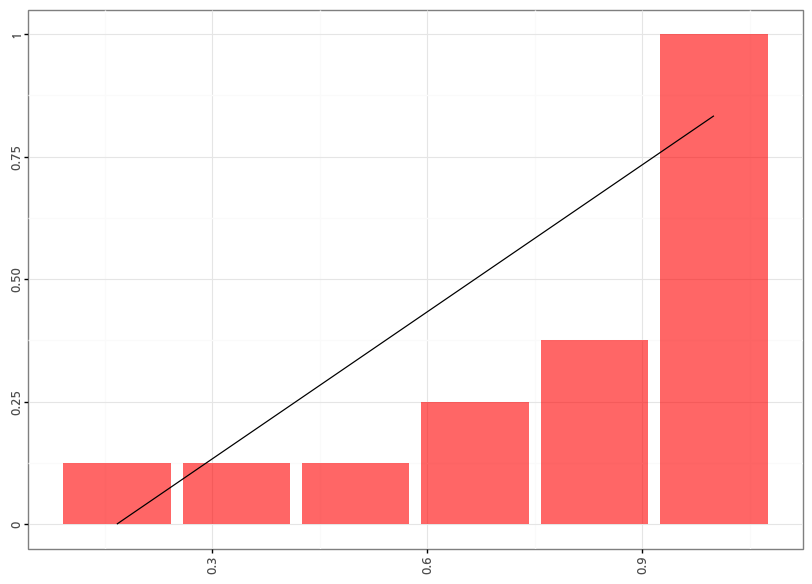


금융/보험 분야 불평등도 = 0.46527777777777785
--------------------------------------------------



38.재개발/재건축 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 101 / 6 / 4
재개발/재건축 분야 총 상담 수 = 10


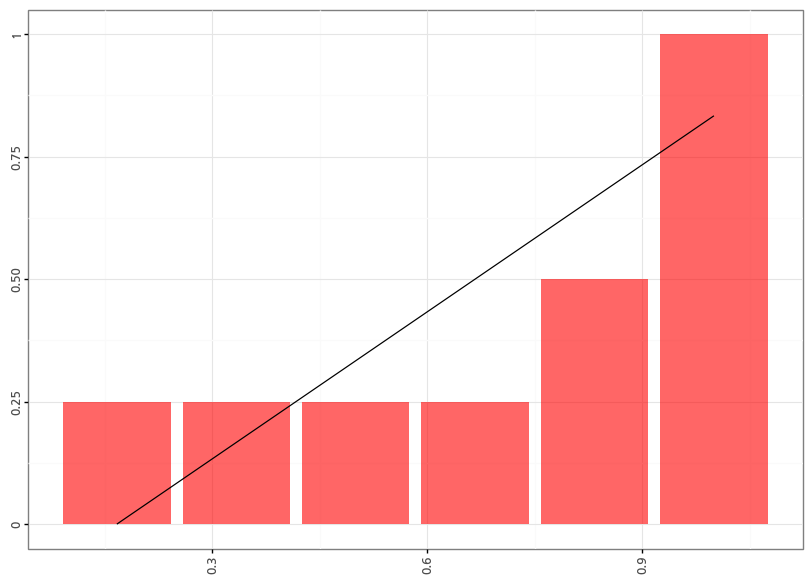


재개발/재건축 분야 불평등도 = 0.3888888888888889
--------------------------------------------------



39.가압류/가처분 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 10 / 7 / 2
가압류/가처분 분야 총 상담 수 = 10


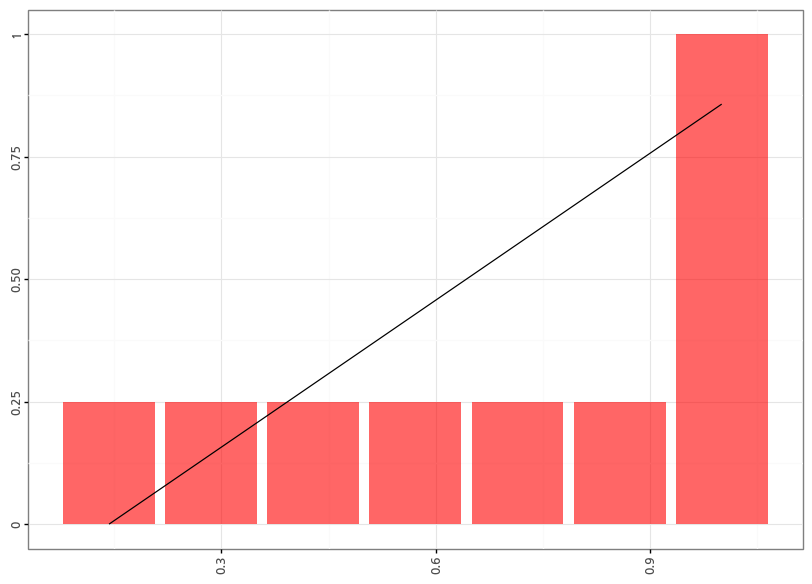


가압류/가처분 분야 불평등도 = 0.5
--------------------------------------------------



40.공증/내용증명/조합/국제문제 등 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 26 / 4 / 2
공증/내용증명/조합/국제문제 등 분야 총 상담 수 = 6


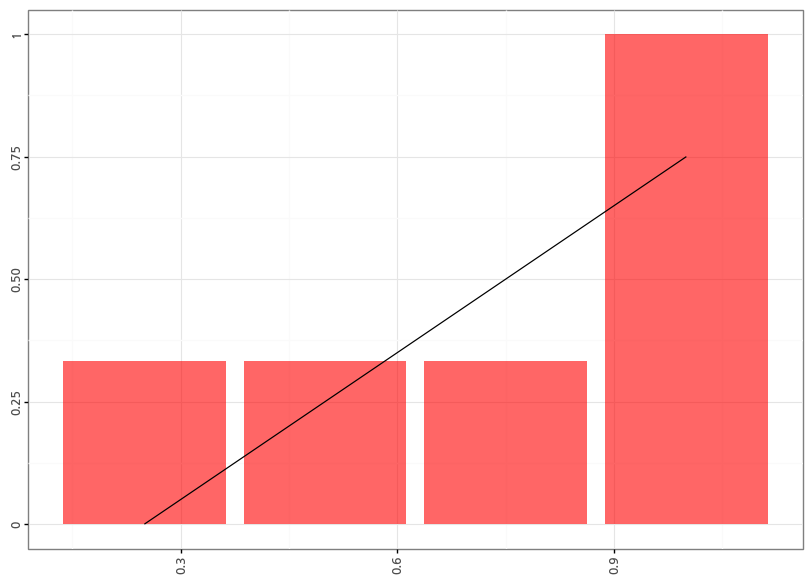


공증/내용증명/조합/국제문제 등 분야 불평등도 = 0.25
--------------------------------------------------





In [11]:
for idx, i in enumerate(extract_advice.groupby("adCategory_name")._id.count().sort_values(ascending = False).index) :
    
    
    # 해당 분야 광고 주
    chk1 = extract_adorders[extract_adorders.adCategory_name == i]
    
    # 해당 분야 유료 상담 변호사
    chk2 = extract_advice[extract_advice.adCategory_name == i].groupby("lawyer_id")._id.count().reset_index()
    
    # 해당 분야 광고 주 중 유료 상담 변호사
    chk3 = chk1[chk1.lawyer_id.isin(chk2.lawyer_id)]
    
    print("{}.{} 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = {} / {} / {}".format(idx+1, i, chk1.lawyer_id.nunique(), chk2.lawyer_id.nunique(), chk3.lawyer_id.nunique()))
    
    print("{} 분야 총 상담 수 = {}".format(i, extract_advice[extract_advice.adCategory_name == i].shape[0]))
    
    print("{} 분야 불평등도 = {}".format(i, get_gini(extract_advice[extract_advice.adCategory_name == i].groupby("lawyer_id")._id.count().reset_index(), "_id")))
    
    print("-"*50)
    print("\n"*2)
    

- 위 집계 기준은 15일 동안 기준이며 상담완료가 아닌 예약 완료 기준(중간에 취소 등이 포함)
- 위 측정기간에서는 상위 11개(건수는 150건, 유료 상담 변호사는 50명 정도 이상) 적절한 불평등도를 확인할 수 있을 것으로 보이나 추후 22일 릴리즈 이후에 탐색을 하면서 적절한 기준을 잡아갈 것

- 한계 : 기존에 공유했지만 지니 계수에서 강조 태그 선택한 변호사의 편향에 따라 불평등이 심화/해소됬다고 보여질 수 있음.
    - 상위/하위 변호사들이 미 선택 : 실제 효과와 상관없이 불평등 해소
    - 중간 변호사 변호사들이 미 선택 : 실제 효과와 상관없이 불평등 심화
    - 결론적으로는 세세한 부분은 실제 배포 후 데이터를 탐색하면서 효과에 대한 의미를 탐색해야할 것

임대차 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = 90 / 56 / 41
임대차 분야 총 상담 수 = 340


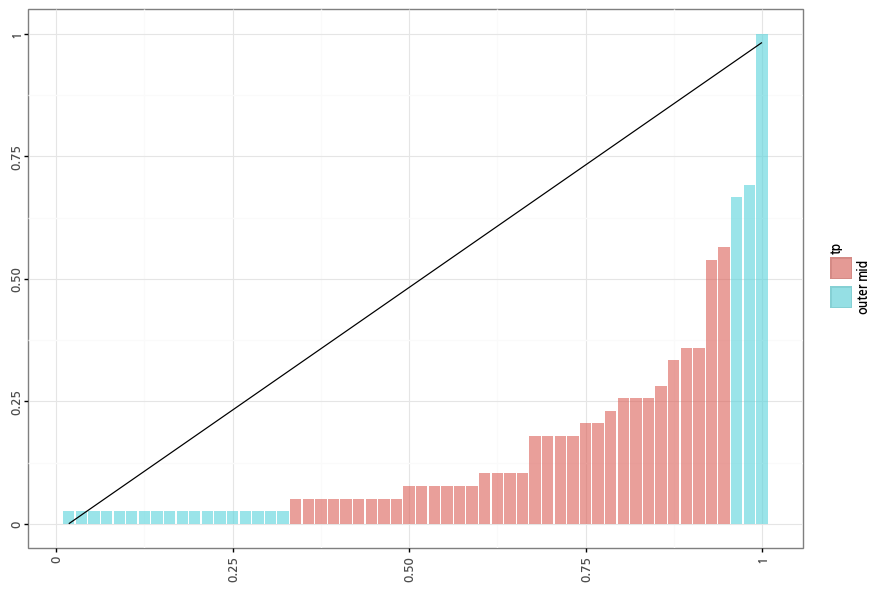


임대차 분야 불평등도 = 0.7518642072213501


In [12]:
i = extract_advice.groupby("adCategory_name")._id.count().sort_values(ascending = False).index[0]

# 해당 분야 광고 주
chk1 = extract_adorders[extract_adorders.adCategory_name == i]

# 해당 분야 유료 상담 변호사
chk2 = extract_advice[extract_advice.adCategory_name == i].groupby("lawyer_id")._id.count().reset_index()

# 해당 분야 광고 주 중 유료 상담 변호사
chk3 = chk1[chk1.lawyer_id.isin(chk2.lawyer_id)]

tmp = extract_advice[extract_advice.adCategory_name == i].groupby("lawyer_id")._id.count().reset_index().assign(tp = lambda x : np.where(x._id.between(2, 22), "mid", "outer"))

print("{} 분야 총 광고 변호사 수 / 상담 변호사 수 / 광고 변호사 중 유료 상담 변호사 = {} / {} / {}".format(i, chk1.lawyer_id.nunique(), chk2.lawyer_id.nunique(), chk3.lawyer_id.nunique()))

print("{} 분야 총 상담 수 = {}".format(i, extract_advice[extract_advice.adCategory_name == i].shape[0]))

print("{} 분야 불평등도 = {}".format(i, get_gini(tmp, "_id", "tp")))

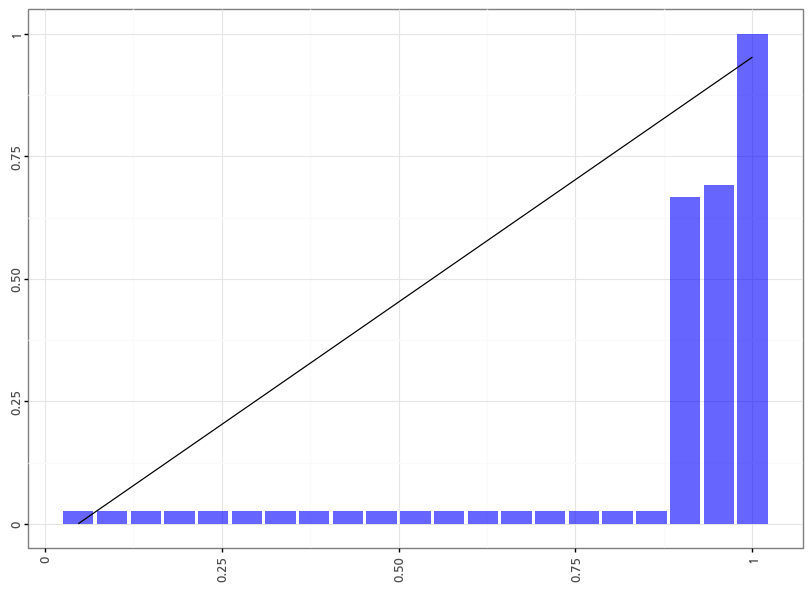

0.7646374789231932

In [13]:
get_gini(tmp[tmp.tp == "outer"], "_id", color = "blue")

In [14]:
get_gini(tmp[tmp.tp == "mid"], "_id")

0.5703153988868274